In [8]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# from numba import jit


# qnode device
dev = qml.device('default.mixed', wires = 2)

# Hamiltonian setup 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
obs_1 = [qml.PauliX(0) @ qml.PauliX(1)]
obs_2 = [qml.PauliY(0) @ qml.PauliY(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [9]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np_.array([0] * 3), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

$$
\rho_{After-Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$


$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [10]:
@qml.qnode(dev)
def circuit_1(paras):
    """ Include the entangler stage and the phase accumulator stage for a 2-qubit system.
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2] as a paramters.
        Set 'phi' from the 'Cost_function' using global variables.
        Dephase_factors = fixed as Tau_global.

    Returns:
        qml.density_matrix: Density matrix of qnode
    """
    
    # Call global phi
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Assign paras
    theta_init, tau_1, tau_2 = paras[0], paras[1], paras[2]
    
    # Calculate dephase factor with fixed tau
    gamma_dephase_in = Dephase_factor(Tau_global)  
    # print(gamma_dephase_in, Dephase_global)
        
    # Stage_1: RY for pi/2
    qml.RY(np.pi / 2, wires = 0)
    qml.RY(np.pi / 2, wires = 1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, -tau_1/2, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)
    qml.PhaseDamping(gamma_dephase_in, wires = 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi / 2, wires = 0)    
    qml.RY(-np.pi / 2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, -tau_2/2, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)
    qml.PhaseDamping(gamma_dephase_in, wires = 1)

    qml.RY(np.pi / 2, wires = 0)    
    qml.RY(np.pi / 2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(hamiltonian, -phi/2, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)
    qml.PhaseDamping(gamma_dephase_in, wires = 1)
    
    # qml.RX(np.pi / 2, wires = 0)
    # qml.RX(np.pi / 2, wires = 1)
    qml.RY(-np.pi/(2 + 1e-3), wires = 0)
    qml.RY(-np.pi/(2 + 1e-3), wires = 1)
    
    return qml.density_matrix(wires=[0, 1])


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = [0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

$$ K =  \begin{bmatrix}
\sqrt{1-\gamma} & 0 \\
0 & 1 
\end{bmatrix}  $$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})}

{Tr[(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})]}
$$

![Alt text](image-1.png)

In [11]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [12]:
# == Check for maximum tau <-> gamma ==
tau_test = 18.7

print('Gamma =', Dephase_factor(tau_test), ', [ at tau =',tau_test,']' )

Gamma = 0.9999999999999999 , [ at tau = 18.7 ]


In [13]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 3 
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

Data = 

array([ [PHI_0, CFI_0, theta_0, tau_1, tau_2, tau_d1, tau_d2, tau_d3], 

...

In [14]:
# == Fixed to gamma_ps = 0.8 ==

# == Sweep for 0 ~ pi*3 == 
Step = np.pi / 25     #1e-1
Sweep_data = np_.array([1e-4, np.pi * 6 + 1e-4, Step])

Para_init = np_.zeros(3)
Para_init[:3] = random.uniform(0, 1)

Gamma_ps_preset = 0.8
Set_Iterations = 5

Optimized_Result = BFGS(Sweep_data, Para_init, Gamma_ps_preset, Set_Iterations)

In [ ]:
# Optimized_Result[:, 0]

# layer = 0 & test_case = 3.01000000e-01
Current_Layer = 1
Optimized_Result[Current_Layer][:, 0 : 2]

# Optimized_Result[0][:,:]

array([[1.00000000e-04, 7.59258769e+00],
       [1.25763706e-01, 9.10706298e+00],
       [2.51427412e-01, 3.85982762e+00],
       [3.77091118e-01, 2.78009832e+00],
       [5.02754825e-01, 6.71471656e+00],
       [6.28418531e-01, 5.46000909e+00],
       [7.54082237e-01, 4.39776265e+00],
       [8.79745943e-01, 3.54606957e+00],
       [1.00540965e+00, 2.88270776e+00],
       [1.13107336e+00, 2.37436331e+00],
       [1.25673706e+00, 1.98881368e+00],
       [1.38240077e+00, 1.69916788e+00],
       [1.50806447e+00, 1.48466567e+00],
       [1.63372818e+00, 1.33020716e+00],
       [1.75939189e+00, 1.22561504e+00],
       [1.88505559e+00, 1.16508175e+00],
       [2.01071930e+00, 1.14703651e+00],
       [2.13638300e+00, 2.88363131e+00],
       [2.26204671e+00, 3.54726713e+00],
       [2.38771042e+00, 4.39928323e+00],
       [2.51337412e+00, 5.46186705e+00],
       [2.63903783e+00, 6.71682358e+00],
       [2.76470154e+00, 8.04114351e+00],
       [2.89036524e+00, 9.07874827e+00],
       [3.016028

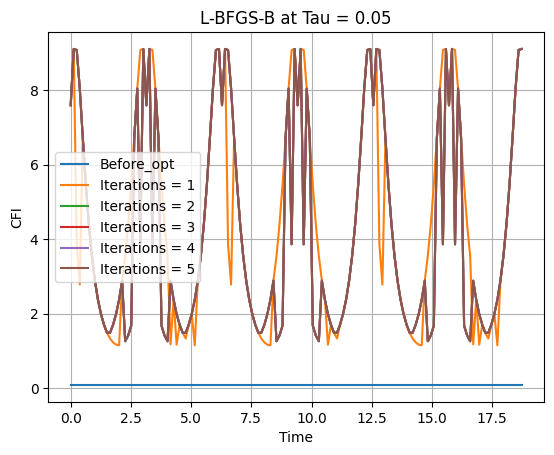

In [ ]:
plt.plot(Optimized_Result[0, : ,0], Optimized_Result[0, : ,1], label = 'Before_opt')
for i in range(1, Set_Iterations + 1):
    plt.plot(Optimized_Result[0, :, 0], Optimized_Result[i, :, 1], label = f'Iterations = {i}')
    
plt.title(f'L-BFGS-B at Tau = {Tau_global}')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

IndexError: tuple index out of range

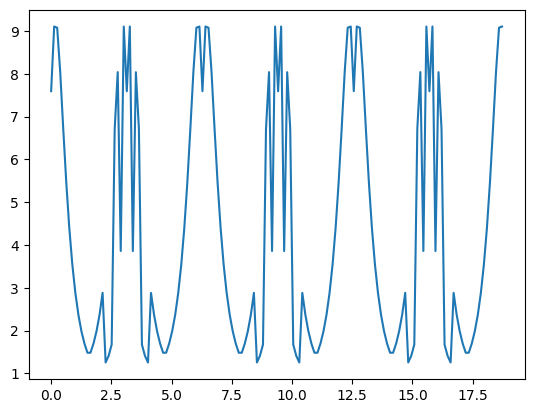

In [ ]:
Target_Layer =  4,
plt.plot(Optimized_Result[Target_Layer[0], :, 0], Optimized_Result[Target_Layer[0], :, 1], 
         label = f'Iterations = {Target_Layer[0]}')

plt.plot(Optimized_Result[Target_Layer[1], :, 0], Optimized_Result[Target_Layer[1], :, 1], 
         label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

In [ ]:
plt.plot(Optimized_Result[1, :, 0], Optimized_Result[Target_Layer[1], :, 1], 
         label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

IndexError: tuple index out of range

In [ ]:
# == Check if optimized results are smaller than the past ==

Flag, Count = 0, 0
Index = np_.zeros(len(Optimized_Result[0, :, 1]))

for i in range(len(Optimized_Result[2, :, 1])):
    Flag = 0 if Optimized_Result[3, i, 1] > Optimized_Result[1, i, 1]  else 1
    if Flag == 1:
        
        Index[Count] = i
        print(i)
        Count = Count + 1

for i in range(len(Index)):
    print(Optimized_Result[1, int(Index[i]), 1], '  ', Optimized_Result[3, int(Index[i]), 1])

6
12
15
18
19
23
25
26
27
29
30
31
32
35
38
48
65
66
68
69
70
73
74
77
80
81
82
85
88
89
95
100
114
115
118
119
123
127
130
131
132
135
138
139
4.397762649366914    4.397762649366818
1.4846656686153006    1.4846656686144617
1.9893447950575354    1.9893447950575034
3.547267127177327    1.2572132360538713
4.399283230708222    1.413175990416817
9.078748274619302    3.8619568239359046
7.595871433406674    7.592587694669605
9.10706297653601    9.107062976534092
9.077662507829963    3.8598276199349444
6.714716562042739    6.714716562042719
5.460009090310032    1.674867034902575
4.397762649366912    1.4128545829722667
3.5460695694512006    1.2570299403259027
1.9888136834655383    1.9888136834655157
1.4849560388075957    1.4849560388074585
9.078748274620606    9.078748274620452
1.9893447950575456    1.9893447950574465
2.3750668631509217    2.3750668631509204
3.547267127177337    1.2572132360536579
4.399283230708417    1.4131759904168084
1.6753945577747262    1.6753945577747051
9.07874827461866

Each row of 6-paras => Corresponds to phi

func(phi, paras, gamma_ps)
=> Implement on SLSQP 

Data = [[phi, CFI, theata_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3] ... N]

In [ ]:
# Bad case after optimization

Num_of_Layer = 1
Condition = np_.where(Optimized_Result[Num_of_Layer][:, 1] < 98)

print('Index:\n', Condition[0])

print('\n')

Optimized_Result[Num_of_Layer, Condition[0], 1]

print('PHI:\n', Optimized_Result[Num_of_Layer, Condition[0], 0], 
      '\n\nCFI\n', Optimized_Result[Num_of_Layer, Condition[0], 1], 
      '\n\nParas\n', Optimized_Result[Num_of_Layer, Condition[0], 2 : ])

Index:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


PHI:
 [1.00000000e-04 1.25763706e-01 2.51427412e-01 3.77091118e-01
 5.02754825e-01 6.28418531e-01 7.54082237e-01 8.79745943e-01
 1.00540965e+00 1.13107336e+00 1.25673706e+00 1.38240077e+00
 1.50806447e+00 1.63372818e+00 1.75939189e+00 1.88505559e+00
 2.01071930e+00 2.13638300e+00 2.26204671e+00 2.38771042e+00
 2.51337412e+00 2.63903783e+00 2.76470154e+00 2.89036524e+00
 3.01602